In [11]:
from reader import parse_data, list_to_freq_dict, parse_data_get_attrib
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import os
import json
import numpy as np
pp = pprint.PrettyPrinter(indent=4)

In [12]:
# Load Dataset

path = 'Train-corpus/'

word_list = []
tag_list = []
word_tags_list = []

for subdir, dirs, files in os.walk(path):
    for file in files:

        fileName = subdir + '/' + str(file)
        words, tags, word_tags = parse_data(fileName)

        word_list.extend(words)
        tag_list.extend(tags)
        word_tags_list.extend(word_tags)


In [13]:
# Generate Frequency Dict for words

word_dict = list_to_freq_dict(word_list)

with open('words.json', 'w') as outfile:
    json.dump(word_dict, outfile, indent=4)

In [14]:
# Print top 10 words

k1 = Counter(word_dict)
top_words = k1.most_common(10)
print('Top 10 Words are: ')
for i in top_words:
    print(i[0], " :", i[1], " ")

Top 10 Words are: 
the  : 525421  
of  : 285406  
to  : 240618  
and  : 234301  
a  : 198729  
in  : 171346  
is  : 91155  
that  : 86423  
was  : 82440  
for  : 79874  


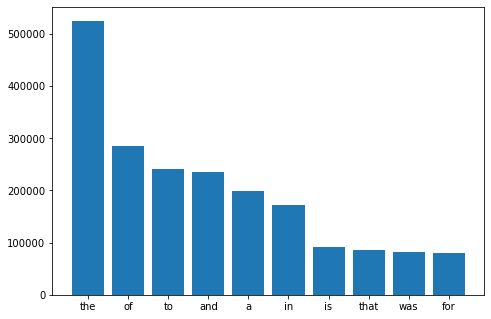

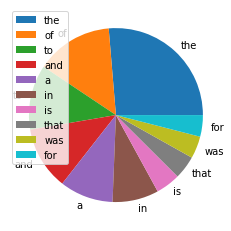

In [15]:
# Plot Top 10 Words

keys, values = [i[0] for i in top_words], [i[1] for i in top_words]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys,values)
plt.show()

patches, texts = plt.pie(values, labels=keys)
plt.legend(patches, keys, loc="best")
plt.savefig('words_chart.png')
plt.show()

In [16]:
# Generate Frequency Dict for tags

tag_dict = list_to_freq_dict(tag_list)
with open('tags.json', 'w') as outfile:
    json.dump(tag_dict, outfile, indent=4)

In [17]:
# Print Top 10 Tags

k1 = Counter(tag_dict)
top_tags = k1.most_common(10)
print('Top 10 Tags are: ')
for i in top_tags:
    print(i[0], " :", i[1], " ")

Top 10 Tags are: 
NN1  : 1573862  
AT0  : 848309  
PRP  : 805618  
AJ0  : 748377  
NN2  : 524728  
NP0  : 505271  
AV0  : 420335  
PNP  : 360704  
CJC  : 317635  
PRF  : 287189  


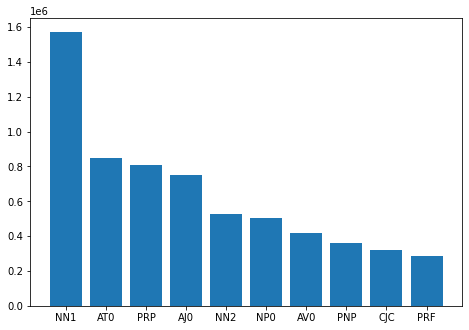

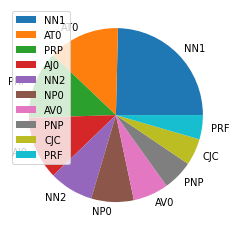

In [18]:
# Plot Top 10 Tags

keys, values = [i[0] for i in top_tags], [i[1] for i in top_tags]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys,values)
plt.show()

patches, texts = plt.pie(values, labels=keys)
plt.legend(patches, keys, loc="best")
plt.savefig('tags_chart.png')
plt.show()

In [19]:
# Generate Frequency Dict for word_tags

word_tags_dict = list_to_freq_dict(word_tags_list)
with open('word_tags.json', 'w') as outfile:
    json.dump(word_tags_dict, outfile, indent=4)

In [21]:
# Load JSON Files

with open('words.json') as f:
    word_dict = json.load(f)
with open('tags.json') as f:
    tag_dict = json.load(f)
with open('word_tags.json') as f:
    word_tags_dict = json.load(f)

In [22]:
print(len(tag_dict))
print(len(word_dict))
print(len(word_tags_dict))

57
192634
252564


In [30]:
def probability_word_given_tag(word, tag):
    # (count word_tag)/(count of tag)
    if word+'_'+tag in word_tags_dict.keys():
        
        count_word_tag = word_tags_dict[word+'_'+tag]
        count_tag = tag_dict[tag]

        return count_word_tag/count_tag
    
    else:
        return 0

In [31]:
# Compute probabilities of each word given a tag

prob_word_tag = np.zeros((len(word_dict)+2, len(tag_dict)+2))

i=0

for word in word_dict:
    j=0
    for tag in tag_dict:
        prob_word_tag[i][j] = probability_word_given_tag(word,tag)
        j=j+1
    i=i+1
        
pp.pprint(prob_word_tag)
# np.savetxt('probability_word_given_tag.txt', prob_word_tag)

array([[7.69492199e-05, 1.46137336e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.56347253e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.02406895e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])


In [32]:
print(probability_word_given_tag('of','PRF'))

0.9937776168307282
